<a href="https://colab.research.google.com/github/HerrSopMod/SalesForecastingModel/blob/main/Modelo/Modelo_Predicciones_Ventas_Oppfi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelo de Proyección de Ventas


In [ ]:
# ============================================================
# LIBRERÍAS Y CONFIGURACIÓN
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Configuración de visualización
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use("default")

print("Entorno y librerías preparadas correctamente.")

Entorno y librerías preparadas correctamente.


In [ ]:
# ============================================================
# DATOS TRIMESTRALES ORIGINALES (HISTÓRICO)
# ============================================================

fechas_q = [
    "2019-03-31","2019-06-30","2019-09-30","2019-12-31",
    "2020-03-31","2020-06-30","2020-09-30","2020-12-31",
    "2021-03-31","2021-06-30","2021-09-30","2021-12-31",
    "2022-03-31","2022-06-30","2022-09-30","2022-12-31",
    "2023-03-31","2023-06-30","2023-09-30","2023-12-31",
    "2024-03-31","2024-06-30","2024-09-30","2024-12-31",
    "2025-03-31","2025-06-30"
]

ventas_q = [
    51,35,48,58,
    26,30,45,56,
    62,67,73,62,
    51,65,53,48,
    57,75,76,66,
    63,86,91,81,
    91,100
]

# Crear DataFrame base
df_q = pd.DataFrame({
    "Fecha": pd.to_datetime(fechas_q),
    "Ventas": ventas_q
}).set_index("Fecha")

print("Datos trimestrales cargados.")
display(df_q.tail()) # Muestra los últimos registros para verificar

Datos trimestrales cargados.


,Ventas
Fecha,
2024-06-30,86
2024-09-30,91
2024-12-31,81
2025-03-31,91
2025-06-30,100


In [ ]:
# ============================================================
# CONVERSIÓN A FRECUENCIA MENSUAL (UPSAMPLING)
# ============================================================

df_m = df_q.resample("M").asfreq()
df_m["Ventas"] = df_m["Ventas"].interpolate(method="linear")

print("Serie mensual generada mediante interpolación.")
print(f"Total puntos de datos mensuales: {len(df_m)}")
display(df_m.head())

Serie mensual generada mediante interpolación.
Total puntos de datos mensuales: 76


/tmp/ipython-input-3644736693.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_m = df_q.resample("M").asfreq()


,Ventas
Fecha,
2019-03-31,51.00
2019-04-30,45.67
2019-05-31,40.33
2019-06-30,35.00
2019-07-31,39.33


In [ ]:
# ============================================================
# ESCALADO Y CREACIÓN DE SECUENCIAS (X, y)
# ============================================================

# 1. Escalar datos (0 a 1)
scaler = MinMaxScaler()
escalado = scaler.fit_transform(df_m[["Ventas"]])

# 2. Función para ventana deslizante (Sliding Window)
def crear_secuencias(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# Definir ventana de observación (6 meses previos para predecir el siguiente)
look_back = 6
X, y = crear_secuencias(escalado, look_back)

# 3. División Entrenamiento (80%) y Prueba (20%)
train_size = int(len(X) * 0.80)
trainX, testX = X[:train_size], X[train_size:]
trainY, testY = y[:train_size], y[train_size:]

# 4. Reshape para LSTM [muestras, pasos de tiempo, características]
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX  = testX.reshape((testX.shape[0], testX.shape[1], 1))

print(f"Dimensiones TrainX: {trainX.shape} | TestX: {testX.shape}")

Dimensiones TrainX: (56, 6, 1) | TestX: (14, 6, 1)


In [ ]:
# ============================================================
# ARQUITECTURA Y ENTRENAMIENTO DEL MODELO LSTM
# ============================================================

model = Sequential()
# Capa LSTM con 50 neuronas
model.add(LSTM(50, input_shape=(look_back, 1)))
# Capa de Salida (1 valor: ventas del mes siguiente)
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

hist = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print("Modelo LSTM entrenado exitosamente.")

Modelo LSTM entrenado exitosamente.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


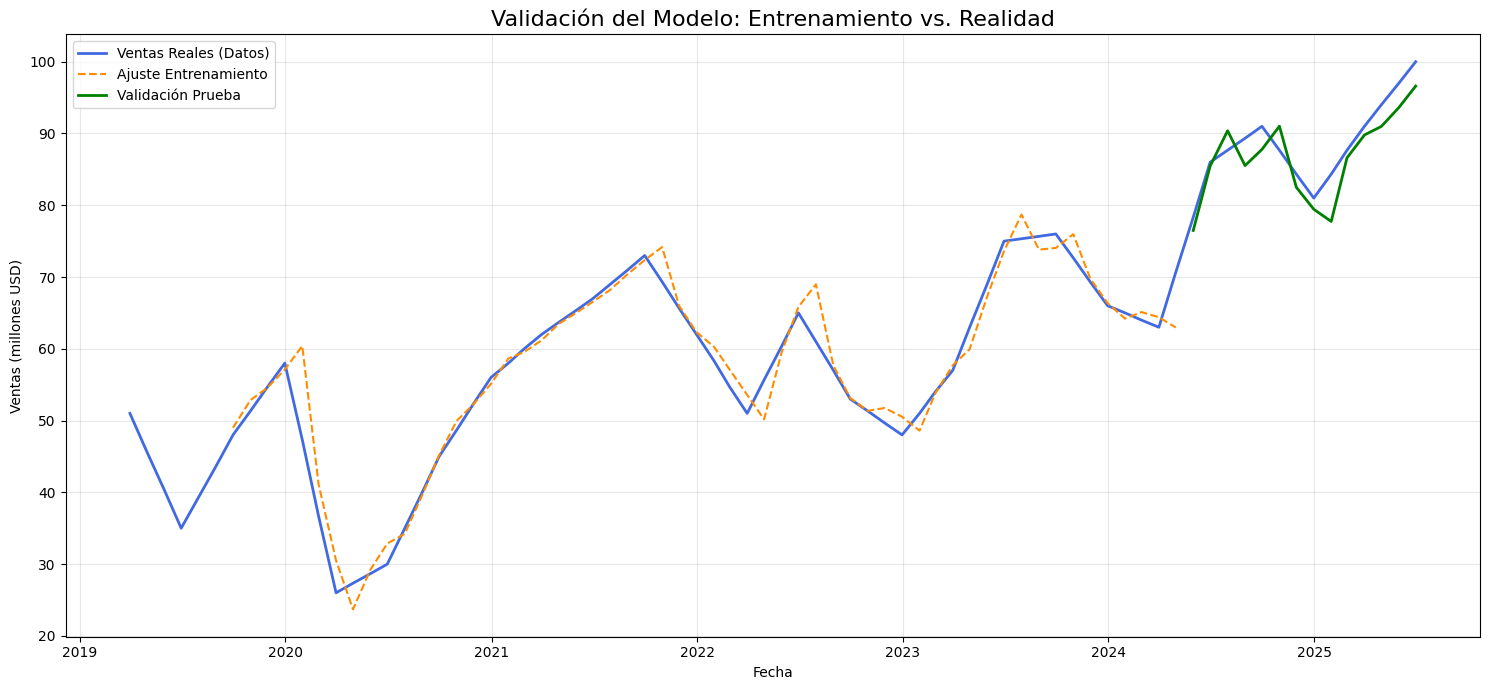

In [ ]:
# ============================================================
# PREDICCIÓN COMPARATIVA Y GRÁFICO DE VALIDACIÓN
# ============================================================

# Generar predicciones sobre los sets
train_pred = scaler.inverse_transform(model.predict(trainX))
test_pred  = scaler.inverse_transform(model.predict(testX))

# Preparar vectores para graficar alineados con las fechas originales
ventas_reales = df_m["Ventas"].values

# Vector para gráfico de entrenamiento
train_plot = np.empty_like(ventas_reales, dtype="float32")
train_plot[:] = np.nan
train_plot[look_back:look_back+len(train_pred)] = train_pred.flatten()

# Vector para gráfico de prueba
test_plot = np.empty_like(ventas_reales, dtype="float32")
test_plot[:] = np.nan
test_plot[look_back+len(train_pred):look_back+len(train_pred)+len(test_pred)] = test_pred.flatten()

# Graficar
plt.figure(figsize=(15,7))
plt.plot(df_m.index, ventas_reales, label="Ventas Reales (Datos)", color="royalblue", linewidth=2)
plt.plot(df_m.index, train_plot, label="Ajuste Entrenamiento", linestyle="--", color="darkorange")
plt.plot(df_m.index, test_plot, label="Validación Prueba", color="green", linewidth=2)

plt.title("Validación del Modelo: Entrenamiento vs. Realidad", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Ventas (millones USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# MÉTRICAS DE DESEMPEÑO
# ============================================================

true_test = scaler.inverse_transform(testY.reshape(-1, 1))

mae  = mean_absolute_error(true_test, test_pred)
rmse = np.sqrt(mean_squared_error(true_test, test_pred))
mape = np.mean(np.abs((true_test - test_pred) / true_test)) * 100
r2   = r2_score(true_test, test_pred)

print("RESUMEN DE MÉTRICAS:")
print("-" * 30)
print(f"MAE (Error Absoluto Medio) : {mae:.2f}")
print(f"RMSE (Raíz Error Cuadrático): {rmse:.2f}")
print(f"MAPE (Error Porcentual)    : {mape:.2f}%")
print(f"R² (Coeficiente Determ.)   : {r2:.4f}")
print("-" * 30)
print(f"Precisión estimada global  : {100 - mape:.2f}%")

RESUMEN DE MÉTRICAS:
------------------------------
MAE (Error Absoluto Medio) : 2.68
RMSE (Raíz Error Cuadrático): 3.06
MAPE (Error Porcentual)    : 3.02%
R² (Coeficiente Determ.)   : 0.7091
------------------------------
Precisión estimada global  : 96.98%


/tmp/ipython-input-1637923008.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1),


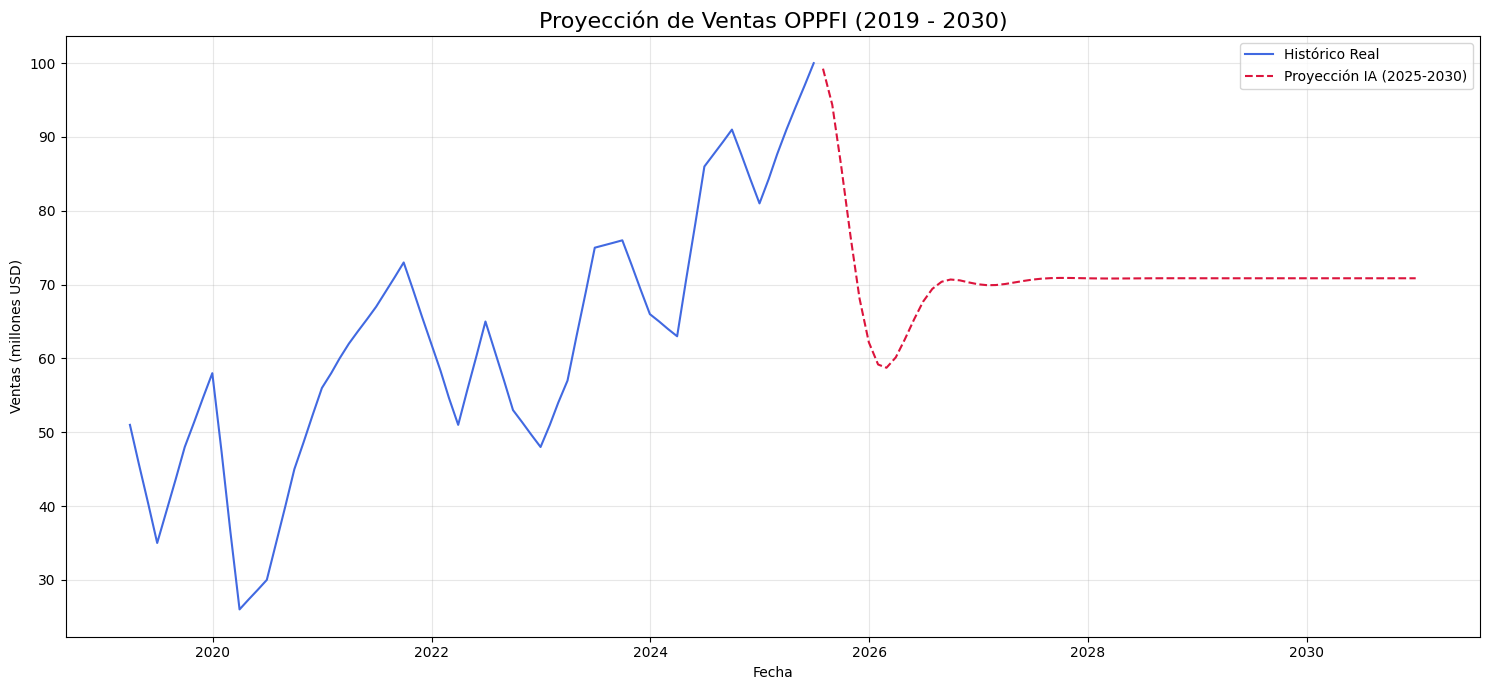

In [ ]:
# ============================================================
# GENERACIÓN DE FUTURO (HASTA 2030)
# ============================================================

# Tomar la última secuencia real disponible para empezar a predecir
last_sequence = escalado[-look_back:].reshape(1, look_back, 1)

last_date = df_m.index[-1]
end_date = pd.to_datetime("2030-12-31")

# Calcular cuántos meses faltan
future_steps = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)

future_preds_scaled = []


for _ in range(future_steps):
    # Predecir el siguiente paso
    pred = model.predict(last_sequence, verbose=0)
    future_preds_scaled.append(pred[0][0])

    # Actualizar la secuencia: quitar el más viejo, agregar la nueva predicción
    last_sequence = np.append(last_sequence[:,1:,:], [[[pred[0][0]]]], axis=1)

# Invertir escala para obtener dólares reales
future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1,1))

# Generar índice de fechas futuras
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1),
                             periods=future_steps, freq="M")

# Crear DataFrame Futuro
df_future = pd.DataFrame({"Ventas": future_preds.flatten()}, index=future_dates)

# Gráfico Final Extendido
plt.figure(figsize=(15,7))
plt.plot(df_m.index, df_m["Ventas"], label="Histórico Real", color="royalblue")
plt.plot(df_future.index, df_future["Ventas"], label="Proyección IA (2025-2030)", color="crimson", linestyle="--")

plt.title("Proyección de Ventas OPPFI (2019 - 2030)", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Ventas (millones USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# REPORTE TRIMESTRAL FINAL
# ============================================================

fechas_trimestrales_objetivo = [
    "2030-12-31","2030-09-30","2030-06-30","2030-03-31",
    "2029-12-31","2029-09-30","2029-06-30","2029-03-31",
    "2028-12-31","2028-09-30","2028-06-30","2028-03-31",
    "2027-12-31","2027-09-30","2027-06-30","2027-03-31",
    "2026-12-31","2026-09-30","2026-06-30","2026-03-31",
    "2025-12-31","2025-09-30","2025-06-30"
]

fechas_trimestrales_dt = pd.to_datetime(fechas_trimestrales_objetivo)

def obtener_prediccion_fecha(fecha):
    # Busca la fecha más cercana en el índice mensual futuro
    try:
        idx = df_future.index.get_indexer([fecha], method="nearest")[0]
        return df_future.iloc[idx, 0]
    except:
        return 0

tabla_pred = pd.DataFrame({
    "Fecha Trimestral": fechas_trimestrales_dt,
    "Predicción (M USD)": [obtener_prediccion_fecha(f) for f in fechas_trimestrales_dt]
}).sort_values("Fecha Trimestral").reset_index(drop=True)

print("REPORTE FINAL DE PREDICCIONES (TRIMESTRES SELECCIONADOS):")
display(tabla_pred)

# Opcional: Descargar a CSV
# tabla_pred.to_csv("predicciones_oppfi_2030.csv", index=False)
# print("CSV generado.")

REPORTE FINAL DE PREDICCIONES (TRIMESTRES SELECCIONADOS):


,Fecha Trimestral,Predicción (M USD)
0,2025-06-30,99.25
1,2025-09-30,85.99
2,2025-12-31,62.19
3,2026-03-31,60.14
4,2026-06-30,67.68
5,2026-09-30,70.69
6,2026-12-31,70.04
7,2027-03-31,70.08
8,2027-06-30,70.67
9,2027-09-30,70.90


# Modelo de Proyección de Estados de Resultados

In [ ]:
# ==========================================
# LIBRERÍAS Y DATOS (2021-2025)
# ==========================================
!pip install prophet -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Configuración de formato para números
pd.options.display.float_format = '{:,.2f}'.format

# Datos históricos
data_hist = {
    "ds": pd.to_datetime(["2021-12-31", "2022-12-31", "2023-12-31", "2024-12-31", "2025-12-31"]),
    "Ingresos totales": [350568000, 452859000, 508949000, 525963000, 555027000],
    "Costo de ingresos": [89168000, 95138000, 107430000, 105183000, 101982000],
    "Gasto operativo": [162033000, 172000000, 168000000, 170000000, 162000000],
    "Gastos netos por ingresos (Financieros)": [-137000, -35000, -40000, -50000, -55000], # Estimado bajo
    "Otros gastos por ingresos": [-85960000, -233906000, -230988000, -204125000, -215000000],
    "Impuestos": [311000, -277000, 2331000, 4215000, 5772000]
}

# Crear DataFrame y calcular campos derivados para consistencia
df_hist = pd.DataFrame(data_hist)
df_hist["Año"] = df_hist["ds"].dt.year
df_hist = df_hist.set_index("Año")

# Fórmulas contables base
df_hist["Beneficio bruto"] = df_hist["Ingresos totales"] - df_hist["Costo de ingresos"]
df_hist["Ingreso operativo (EBIT)"] = df_hist["Beneficio bruto"] - df_hist["Gasto operativo"]
df_hist["Ingreso antes de impuestos"] = (df_hist["Ingreso operativo (EBIT)"] +
                                         df_hist["Gastos netos por ingresos (Financieros)"] +
                                         df_hist["Otros gastos por ingresos"])
df_hist["Ingreso neto incluyendo intereses minoritarios"] = df_hist["Ingreso antes de impuestos"] - df_hist["Impuestos"]

print("Datos históricos cargados.")

Datos históricos cargados.


In [ ]:
# ==========================================
# PROYECCIÓN (2026-2030)
# ==========================================

# 1. IA: Proyección de Ingresos
m = Prophet(growth='linear', changepoint_prior_scale=0.1)
df_prophet = df_hist.reset_index()[["ds", "Ingresos totales"]].rename(columns={"Ingresos totales": "y"})
m.fit(df_prophet)

future = m.make_future_dataframe(periods=5, freq='Y')
forecast = m.predict(future)
ventas_futuras = forecast.tail(5)["yhat"].values
anios_futuros = [2026, 2027, 2028, 2029, 2030]

# 2. FÓRMULAS: Cálculo de Ratios (% sobre Ventas de últimos 3 años)
cols_dependientes = ["Costo de ingresos", "Gasto operativo",
                     "Otros gastos por ingresos", "Impuestos",
                     "Gastos netos por ingresos (Financieros)"]
ratios = {}
for col in cols_dependientes:
    ratios[col] = (df_hist[col] / df_hist["Ingresos totales"]).tail(3).mean()

# 3. CONSTRUCCIÓN: Aplicar ratios a las ventas proyectadas
proyeccion = []
for i, anio in enumerate(anios_futuros):
    v = ventas_futuras[i]
    fila = {"Ingresos totales": v}

    # Aplicar ratios
    for col in cols_dependientes:
        fila[col] = v * ratios[col]

    # Calcular totales (Identidad contable)
    fila["Beneficio bruto"] = fila["Ingresos totales"] - fila["Costo de ingresos"]
    fila["Ingreso operativo (EBIT)"] = fila["Beneficio bruto"] - fila["Gasto operativo"]
    fila["Ingreso antes de impuestos"] = (fila["Ingreso operativo (EBIT)"] +
                                          fila["Gastos netos por ingresos (Financieros)"] +
                                          fila["Otros gastos por ingresos"])
    fila["Ingreso neto incluyendo intereses minoritarios"] = fila["Ingreso antes de impuestos"] - fila["Impuestos"]

    proyeccion.append(fila)

df_proy = pd.DataFrame(proyeccion, index=anios_futuros)
df_total = pd.concat([df_hist, df_proy])

print("Modelo calculado (2026-2030).")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.


Modelo calculado (2026-2030).


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [ ]:
# ==========================================
# VISUALIZACIÓN DE TABLA
# ==========================================

orden_filas = [
    "Ingresos totales", "Costo de ingresos", "Beneficio bruto",
    "Gasto operativo", "Ingreso operativo (EBIT)",
    "Gastos netos por ingresos (Financieros)", "Otros gastos por ingresos",
    "Ingreso antes de impuestos", "Ingreso neto incluyendo intereses minoritarios"
]

tabla_final = df_proy[orden_filas].T

print("PROYECCIONES ESTADO DE RESULTADOS (2026-2030)")
# Estilo para formato moneda y limpieza
display(tabla_final.style.format("{:,.2f}").background_gradient(cmap="Reds", axis=1, subset=pd.IndexSlice[["Ingresos totales", "Ingreso neto incluyendo intereses minoritarios"], :]))

PROYECCIONES ESTADO DE RESULTADOS (2026-2030)


,2026,2027,2028,2029,2030
Ingresos totales,"590,219,848.47","631,475,120.98","639,541,884.73","668,605,886.64","703,798,733.84"
Costo de ingresos,"117,022,144.44","125,201,775.25","126,801,162.32","132,563,645.30","139,541,286.69"
Beneficio bruto,"473,197,704.03","506,273,345.73","512,740,722.41","536,042,241.34","564,257,447.14"
Gasto operativo,"185,955,916.27","198,953,889.86","201,495,421.54","210,652,387.58","221,740,320.60"
Ingreso operativo (EBIT),"287,241,787.76","307,319,455.87","311,245,300.87","325,389,853.77","342,517,126.54"
Gastos netos por ingresos (Financieros),"-53,661.08","-57,411.89","-58,145.30","-60,787.72","-63,987.35"
Otros gastos por ingresos,"-241,856,182.43","-258,761,480.93","-262,067,023.24","-273,976,667.70","-288,397,747.74"
Ingreso antes de impuestos,"45,331,944.24","48,500,563.05","49,120,132.32","51,352,398.35","54,055,391.46"
Ingreso neto incluyendo intereses minoritarios,"40,808,225.37","43,660,644.62","44,218,386.47","46,227,892.50","48,661,151.29"


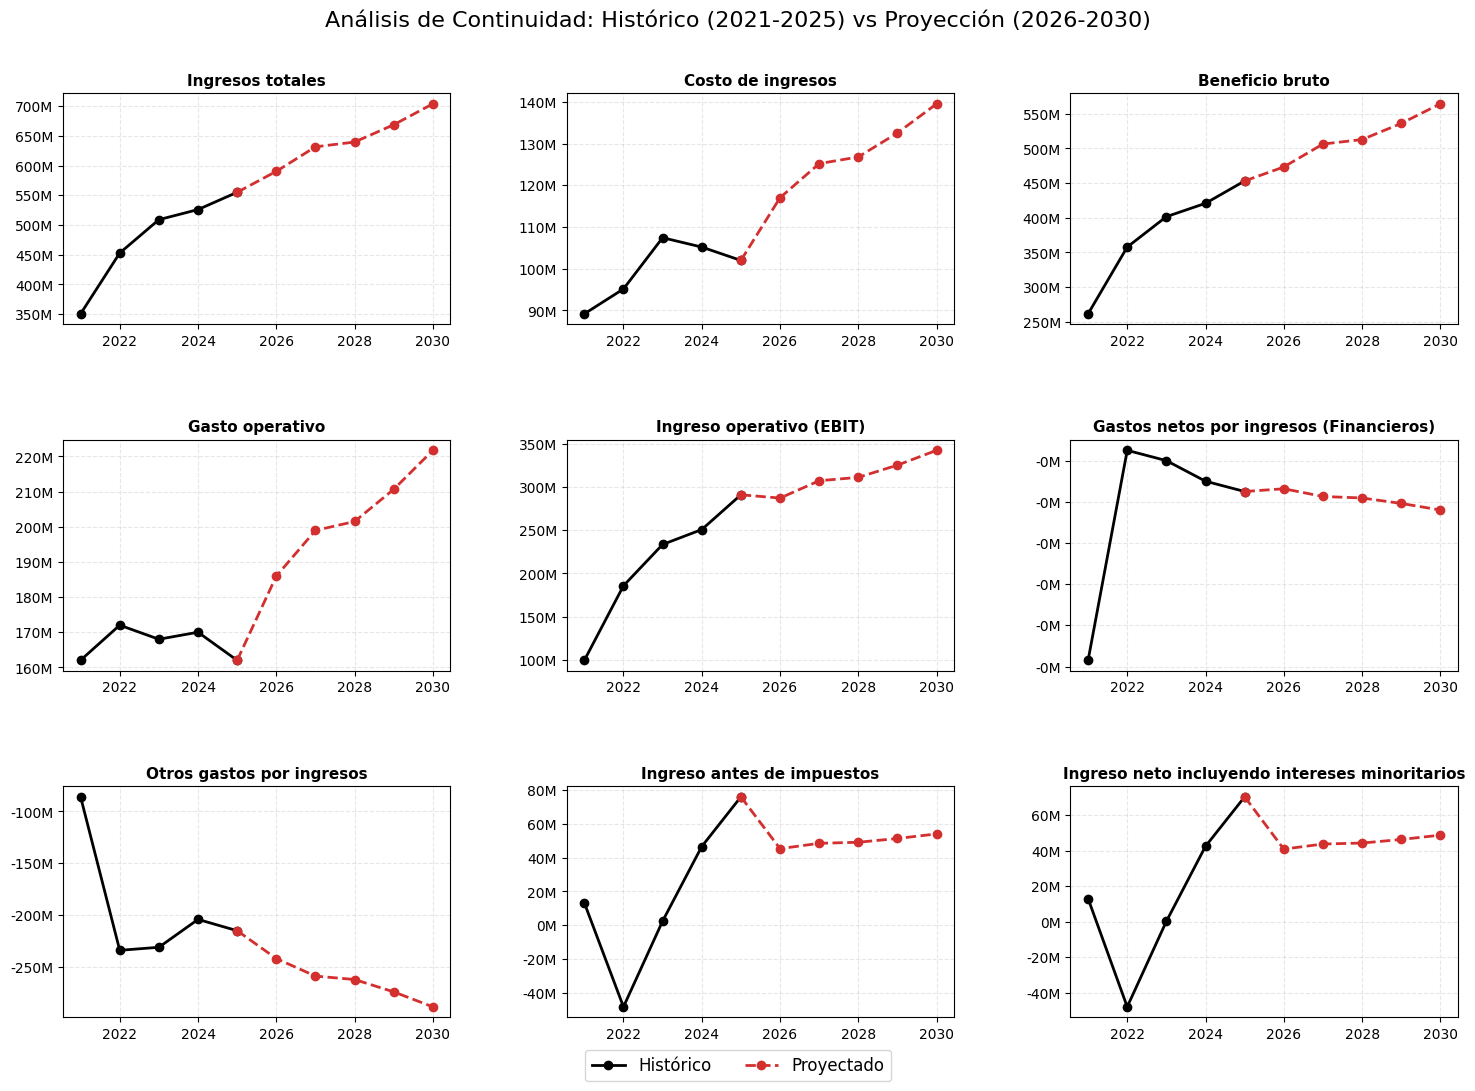

In [ ]:
# ==========================================
# GRÁFICOS DE CONTINUIDAD
# ==========================================

plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, col in enumerate(orden_filas):
    ax = plt.subplot(3, 3, i + 1)

    # Datos
    y_hist = df_total.loc[:2025, col]
    y_proy = df_total.loc[2025:, col]

    # Graficar
    ax.plot(y_hist.index, y_hist, label="Histórico", color='black', marker='o', lw=2)
    ax.plot(y_proy.index, y_proy, label="Proyectado", color='#D32F2F', linestyle='--', marker='o', lw=2)

    # Formato
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.tick_params(axis='x', rotation=0)

    # Formato eje Y (Millones "M")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.05))
plt.suptitle("Análisis de Continuidad: Histórico (2021-2025) vs Proyección (2026-2030)", fontsize=16, y=0.95)

plt.show()

# Modelo de Proyección de Balance General

In [ ]:
# ==========================================
# DATOS HISTÓRICOS (2021-2024)
# ==========================================
!pip install prophet -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

pd.options.display.float_format = '{:,.2f}'.format

# 1. Datos del Balance General
data_bs = {
    "ds": pd.to_datetime(["2021-12-31", "2022-12-31", "2023-12-31", "2024-12-31"]),
    "Activos Totales": [502106000, 579839000, 601543000, 641171000],
    "Efectivo y Equiv.": [25064000, 16239000, 31791000, 61344000],
    "Cuentas por Cobrar (Neto)": [388110000, 459939000, 465334000, 475732000], # Principal activo
    "Otros Activos Corrientes": [37298000, 33981000, 42152000, 26944000], # Efectivo restringido + otros
    "Activos No Corrientes (PPE + Otros)": [51634000, 69680000, 62266000, 77151000],

    "Pasivos Totales": [344228000, 420689000, 407514000, 406958000],
    "Cuentas por Pagar y Acum.": [35695000, 55183000, 51473000, 59798000],
    "Deuda LP y Arrendamiento": [274021000, 363618000, 349177000, 332052000], # Principal pasivo
    "Otros Pasivos": [34512000, 1888000, 6864000, 15108000],

    "Patrimonio Total": [157878000, 159150000, 194029000, 234213000]
}

df_bs = pd.DataFrame(data_bs)
df_bs["Año"] = df_bs["ds"].dt.year
df_bs = df_bs.set_index("Año")

# 2. Datos de Ventas
ventas_hist = {
    2021: 350568000,
    2022: 452859000,
    2023: 508949000,
    2024: 525963000
}
df_bs["Ventas_Ref"] = df_bs.index.map(ventas_hist)

print("Datos de Balance cargados y vinculados con Ventas.")

Datos de Balance cargados y vinculados con Ventas.


In [ ]:
# ==========================================
# PROYECCIÓN BALANCE (2025-2030)
# ==========================================

# 1. Prophet:
m = Prophet(growth='linear', changepoint_prior_scale=0.1)
df_prophet = df_bs.reset_index()[["ds", "Ventas_Ref"]].rename(columns={"Ventas_Ref": "y"})
m.fit(df_prophet)

future = m.make_future_dataframe(periods=6, freq='Y') # 2025 a 2030
forecast = m.predict(future)
ventas_futuras = forecast.tail(6)["yhat"].values
anios_futuros = [2025, 2026, 2027, 2028, 2029, 2030]

# 2. Fórmulas: Calcular Ratios (% sobre Ventas de últimos 3 años)
cols_drivers = ["Efectivo y Equiv.", "Cuentas por Cobrar (Neto)",
                "Otros Activos Corrientes", "Activos No Corrientes (PPE + Otros)",
                "Cuentas por Pagar y Acum.", "Deuda LP y Arrendamiento", "Otros Pasivos"]

ratios = {}
for col in cols_drivers:
    # Promedio 2022-2024 para capturar tendencia reciente
    ratios[col] = (df_bs[col] / df_bs["Ventas_Ref"]).tail(3).mean()

# 3. Construcción del Balance Futuro
proyeccion = []

for i, anio in enumerate(anios_futuros):
    v = ventas_futuras[i]
    fila = {}

    # a) Proyectar Activos y Pasivos basados en Ventas
    total_activos = 0
    total_pasivos = 0

    for col in cols_drivers:
        valor_proy = v * ratios[col]
        fila[col] = valor_proy

        # Sumarizadores
        if "Activo" in col or "Efectivo" in col or "Cuentas por Cobrar" in col:
            total_activos += valor_proy
        else:
            total_pasivos += valor_proy

    fila["Activos Totales"] = total_activos
    fila["Pasivos Totales"] = total_pasivos

    # b) Calcular Patrimonio para que cuadre (Activo - Pasivo)
    fila["Patrimonio Total"] = total_activos - total_pasivos

    proyeccion.append(fila)

df_proy_bs = pd.DataFrame(proyeccion, index=anios_futuros)
df_total_bs = pd.concat([df_bs.drop(columns=["ds", "Ventas_Ref"]), df_proy_bs])

print("Balance General Proyectado y Cuadrado.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.


Balance General Proyectado y Cuadrado.


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [ ]:
# ==========================================
# VISUALIZACIÓN DE TABLA
# ==========================================

# Orden lógico del Balance
orden_filas = [
    "Activos Totales",
    "Efectivo y Equiv.", "Cuentas por Cobrar (Neto)",
    "Activos No Corrientes (PPE + Otros)",
    "Pasivos Totales",
    "Cuentas por Pagar y Acum.", "Deuda LP y Arrendamiento",
    "Patrimonio Total"
]

tabla_final = df_proy_bs[orden_filas].T

print("PROYECCIÓN BALANCE GENERAL (2025-2030)")
display(tabla_final.style.format("{:,.2f}").background_gradient(cmap="Blues", axis=1, subset=pd.IndexSlice[["Activos Totales", "Patrimonio Total"], :]))

PROYECCIÓN BALANCE GENERAL (2025-2030)


,2025,2026,2027,2028,2029,2030
Activos Totales,"744,197,101.52","827,974,561.08","896,803,914.60","917,682,184.77","1,016,457,895.24","1,100,235,354.80"
Efectivo y Equiv.,"43,453,555.26","48,345,308.35","52,364,243.80","53,583,322.81","59,350,821.48","64,242,574.57"
Cuentas por Cobrar (Neto),"572,987,269.68","637,490,904.15","690,485,390.79","706,560,410.42","782,611,801.29","847,115,435.77"
Activos No Corrientes (PPE + Otros),"85,489,040.21","95,112,908.13","103,019,624.45","105,417,998.86","116,764,778.72","126,388,646.63"
Pasivos Totales,"506,067,513.50","563,037,704.00","609,842,911.55","624,040,513.57","691,209,786.45","748,179,976.95"
Cuentas por Pagar y Acum.,"68,061,208.54","75,723,150.70","82,018,000.51","83,927,441.30","92,961,061.85","100,623,004.00"
Deuda LP y Arrendamiento,"428,630,457.52","476,883,226.51","516,526,430.22","528,551,554.31","585,442,770.21","633,695,539.19"
Patrimonio Total,"238,129,588.02","264,936,857.08","286,961,003.05","293,641,671.20","325,248,108.79","352,055,377.84"


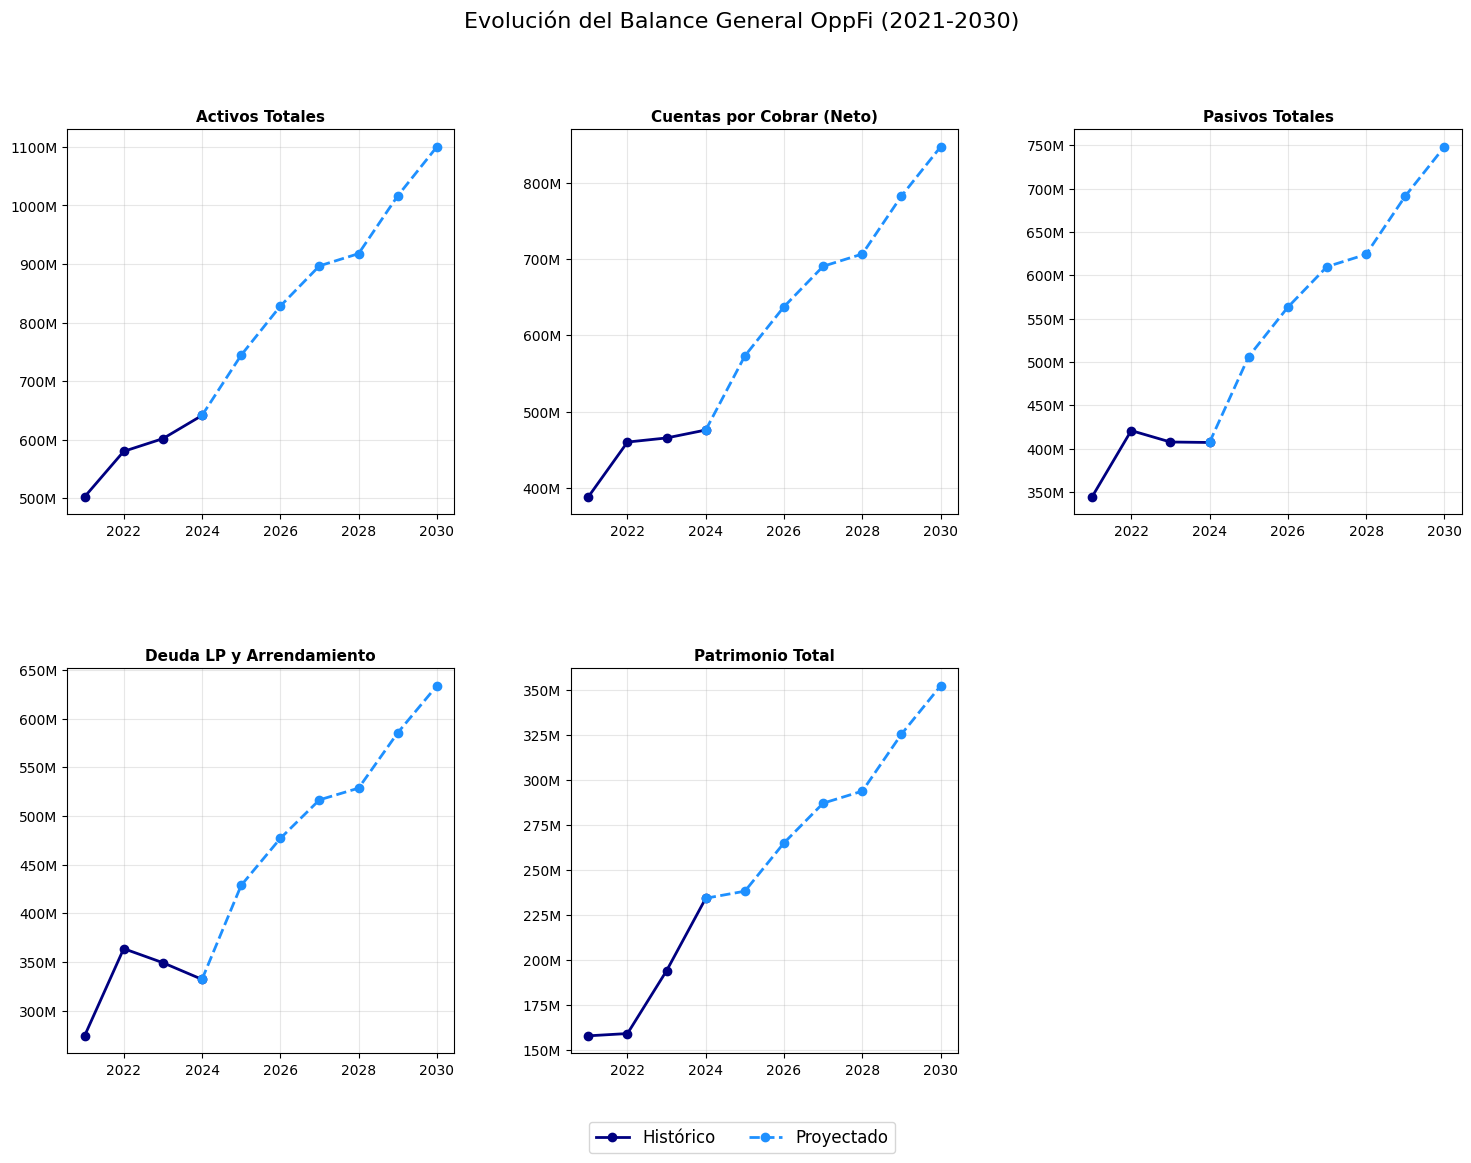

In [ ]:
# ==========================================
# GRÁFICOS DE TENDENCIA
# ==========================================

plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

cuentas_grafico = ["Activos Totales", "Cuentas por Cobrar (Neto)",
                   "Pasivos Totales", "Deuda LP y Arrendamiento", "Patrimonio Total"]

for i, col in enumerate(cuentas_grafico):
    ax = plt.subplot(2, 3, i + 1)

    y_hist = df_total_bs.loc[:2024, col]
    y_proy = df_total_bs.loc[2024:, col]

    ax.plot(y_hist.index, y_hist, label="Histórico", color='navy', marker='o', lw=2)
    ax.plot(y_proy.index, y_proy, label="Proyectado", color='dodgerblue', linestyle='--', marker='o', lw=2)

    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.0f}M'))

handles, labels = ax.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.02))
plt.suptitle("Evolución del Balance General OppFi (2021-2030)", fontsize=16)

plt.show()